# Heatmaps for DOP and Cramer Rao Bounds

In [67]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
# We need to join the upper directory in order to access the local modules
import datetime
import os
import pickle
import sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

import itertools
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy

In [69]:
plt.rcParams["font.family"] = "Linux Libertine O"
plt.rcParams["font.size"] = 20

In [70]:
with open("comnets_data/gnbPositions.json") as gnb_file:
    data = json.load(gnb_file)

gNBs = np.array([data["gnb0"], data["gnb1"], data["gnb2"], data["gnb3"]])

with open("comnets_data/uePositions.json") as ue_file:
    data = json.load(ue_file)

UEs = np.array(
    [data["ue0"], data["ue1"], data["ue2"], data["ue3"], data["ue4"], data["ue5"]]
)

## Dilution of Precision

Dilution of Precision is easiear to calculate as it depends on geometric parameters (CRLB under constant variance depends only on that too :D)
https://en.wikipedia.org/wiki/Dilution_of_precision_(navigation)

In [72]:
from util import dop, crlb

In [93]:
d = dop(UEs[0:5,:].reshape(-1,2), gNBs)
d

array([[0.74903655, 0.06823607],
       [0.78901503, 0.06910904],
       [0.48230421, 0.07205499],
       [0.48387948, 0.07680169],
       [0.34827208, 0.0817966 ]])

In [90]:
cr = crlb(UEs[0:5,:].reshape(-1,2), gNBs)
cr

array([[8.51538732, 0.77573857],
       [8.9698808 , 0.7856629 ],
       [5.4830531 , 0.8191538 ],
       [5.50096146, 0.87311647],
       [3.95931497, 0.92990089]])

In [94]:
d / cr

array([[0.08796271, 0.08796271],
       [0.08796271, 0.08796271],
       [0.08796271, 0.08796271],
       [0.08796271, 0.08796271],
       [0.08796271, 0.08796271]])

In [65]:
n = 100
x = np.linspace(np.min(gNBs[:,0])-5.0,np.max(gNBs[:,0])+5,100,endpoint=True)
y = np.linspace(np.min(gNBs[:,1])-5.0,np.max(gNBs[:,1])+5,100,endpoint=True)

xx, yy = np.meshgrid(x,y)

ps = np.hstack((xx.flatten().reshape(-1,1),yy.flatten().reshape(-1,1)))
dp = dop(ps, gNBs)
xdop = np.sqrt(dp[:,0]).reshape(xx.shape)
ydop = np.sqrt(dp[:,1]).reshape(yy.shape)
hdop = np.sqrt(np.sum(dp,axis=1)).reshape(yy.shape)

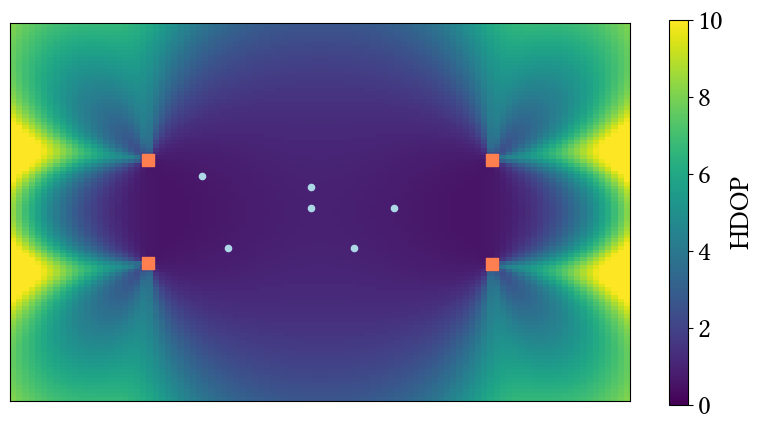

In [66]:
fig, ax = plt.subplots(figsize=(10, 5))

im = ax.pcolormesh(y,x,hdop.T,vmin=0.0,vmax=10)
c = fig.colorbar(im, ax=ax)
c.ax.set_ylabel('HDOP')

ax.set_xticks([])
ax.set_yticks([])

ax.scatter(UEs[:,1],UEs[:,0], 20, 'lightblue', 'o')
ax.scatter(gNBs[:,1], gNBs[:,0], 80, 'coral', 's')

plt.gca().invert_yaxis()
plt.gca().set_aspect('equal')
plt.show()

In [44]:
gNBs

array([[ 3.87, 12.81],
       [ 0.  , 12.81],
       [ 0.  ,  0.  ],
       [ 3.84,  0.  ]])

In [32]:
UEs

array([[1.8 , 6.07],
       [1.  , 6.07],
       [1.8 , 9.14],
       [3.28, 2.97],
       [0.58, 2.03],
       [5.28, 7.68]])

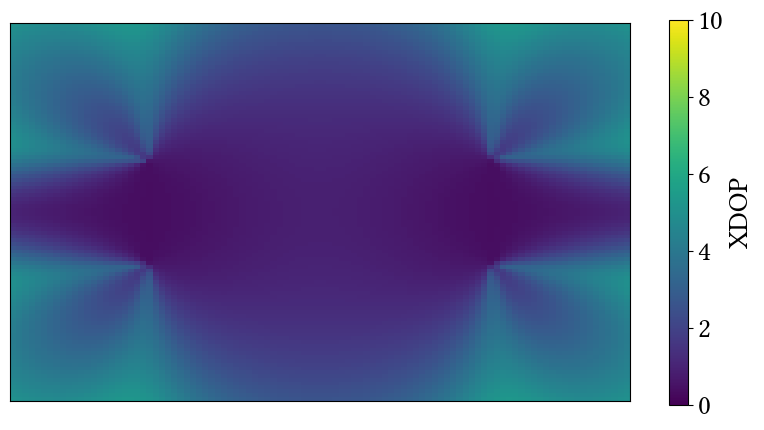

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))

im = ax.pcolormesh(y,x,xdop.T,vmin=0.0,vmax=10)
c = fig.colorbar(im, ax=ax)
c.ax.set_ylabel('XDOP')

ax.set_xticks([])
ax.set_yticks([])

plt.gca().set_aspect('equal')
plt.show()

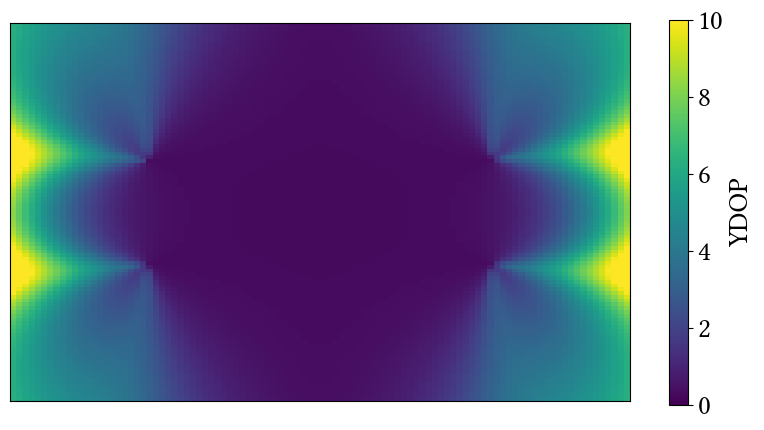

In [21]:
fig, ax = plt.subplots(figsize=(10, 5))

im = ax.pcolormesh(y,x,ydop.T,vmin=0.0,vmax=10)
c = fig.colorbar(im, ax=ax)
c.ax.set_ylabel('YDOP')

ax.set_xticks([])
ax.set_yticks([])

plt.gca().set_aspect('equal')
plt.show()